In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os
import torch
assert torch.cuda.is_available()
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
from multiprocessing import cpu_count
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import cv2
import numpy as np
from torchsummary import summary

In [ ]:
path_to_data = '/content/drive/MyDrive/Math 156 Project/real_and_fake_face' # insert path to data here

# define transforms for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize
])

# load data
dataset = datasets.ImageFolder(root=path_to_data, transform=transform)

In [ ]:
# confirm class labels for real and fake
fake_label = dataset.class_to_idx['training_fake']
real_label = dataset.class_to_idx['training_real']

print(f"Label for fake images: {fake_label}")
print(f"Label for real images: {real_label}")

Label for fake images: 0
Label for real images: 1


## Model with avg pooling layers

In [ ]:
assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_size = int(0.8 * len(dataset)) # 80% training data
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=cpu_count())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=cpu_count())

train_data = [(inputs.to(device), labels.to(device)) for inputs, labels in train_loader]
val_data = [(inputs.to(device), labels.to(device)) for inputs, labels in val_loader]

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

        self.relu = nn.ReLU() # activation
        self.pool = nn.AvgPool2d(2, 2) # avg pooling layer
        self.sigmoid = nn.Sigmoid() # binary output

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # flatten output for hidden layer

        # apply activations
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
model = CNN()

model.to(device)
train_losses_avg = []
val_losses_avg = []
train_accuracies_avg = []
val_accuracies_avg = []

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # learning rate originally 0.1

In [ ]:
# train model
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_data:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        probabilities = torch.sigmoid(outputs.squeeze())
        predictions = (probabilities > 0.5).float()
        correct_train += (predictions == labels).float().sum()
        total_train += labels.size(0)
        running_loss += loss.item()

    train_accuracy = correct_train / total_train
    epoch_train_loss = running_loss / len(train_data)
    epoch_train_accuracy = correct_train / total_train
    train_losses_avg.append(epoch_train_loss)  # Append average loss for the epoch
    train_accuracies_avg.append(epoch_train_accuracy)  # Append accuracy for the epoch

    model.eval()

    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_data:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            probabilities = torch.sigmoid(outputs.squeeze())
            predictions = (probabilities > 0.5).float()
            correct_val += (predictions == labels).float().sum()
            total_val += labels.size(0)
            val_loss += loss.item()

    val_accuracy = correct_val / total_val
    epoch_val_loss = val_loss / len(val_data)
    epoch_val_accuracy = correct_val / total_val
    val_losses_avg.append(epoch_val_loss)  # Append average loss for the epoch
    val_accuracies_avg.append(epoch_val_accuracy)  # Append accuracy for the epoch

    # print results for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

Epoch 1/200 - Loss: 0.7096, Train Accuracy: 0.5184, Val Loss: 0.6826, Val Accuracy: 0.5746
Epoch 2/200 - Loss: 0.6994, Train Accuracy: 0.5184, Val Loss: 0.6816, Val Accuracy: 0.5746
Epoch 3/200 - Loss: 0.6939, Train Accuracy: 0.5184, Val Loss: 0.6831, Val Accuracy: 0.5746
Epoch 4/200 - Loss: 0.6923, Train Accuracy: 0.5184, Val Loss: 0.6844, Val Accuracy: 0.5746
Epoch 5/200 - Loss: 0.6918, Train Accuracy: 0.5184, Val Loss: 0.6850, Val Accuracy: 0.5746
Epoch 6/200 - Loss: 0.6915, Train Accuracy: 0.5184, Val Loss: 0.6854, Val Accuracy: 0.5746
Epoch 7/200 - Loss: 0.6914, Train Accuracy: 0.5184, Val Loss: 0.6855, Val Accuracy: 0.5746
Epoch 8/200 - Loss: 0.6913, Train Accuracy: 0.5184, Val Loss: 0.6854, Val Accuracy: 0.5746
Epoch 9/200 - Loss: 0.6912, Train Accuracy: 0.5184, Val Loss: 0.6853, Val Accuracy: 0.5746
Epoch 10/200 - Loss: 0.6910, Train Accuracy: 0.5184, Val Loss: 0.6851, Val Accuracy: 0.5746
Epoch 11/200 - Loss: 0.6909, Train Accuracy: 0.5184, Val Loss: 0.6849, Val Accuracy: 0.57

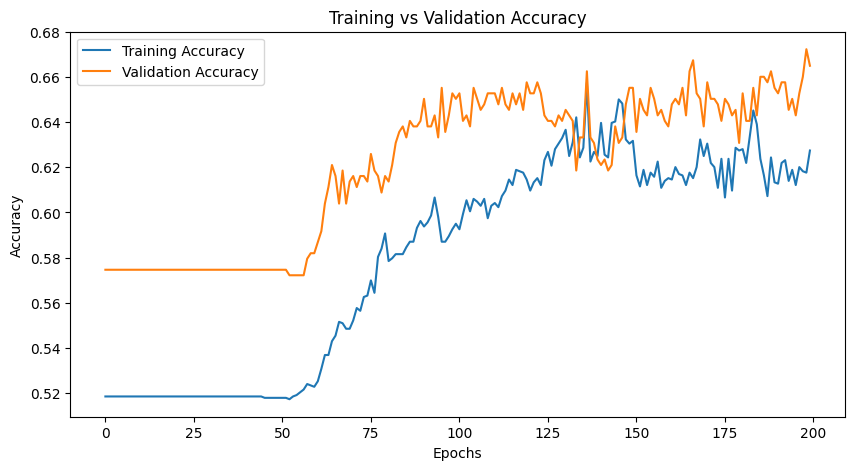

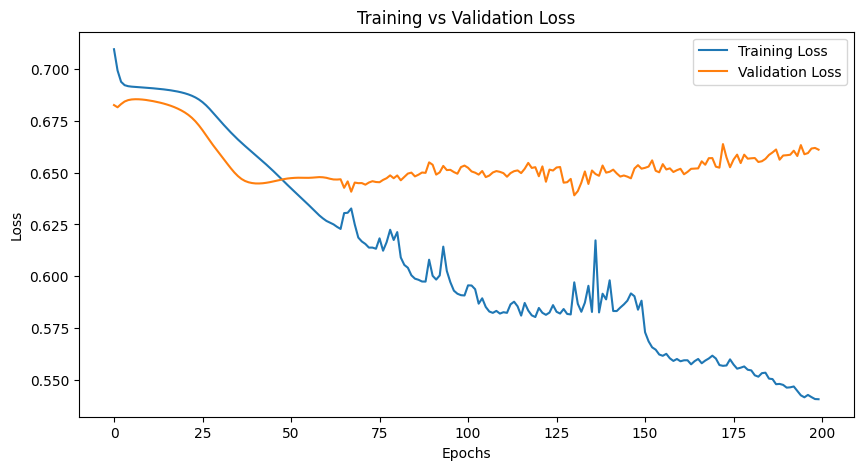

In [ ]:
train_acc_avg = [x.item() for x in train_accuracies_avg]  # Assuming train_accuracies is similar to val_accuracies
val_acc_avg = [x.item() for x in val_accuracies_avg]

# Plot for training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_avg, label='Training Accuracy')
plt.plot(val_acc_avg, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot for training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses_avg, label='Training Loss')
plt.plot(val_losses_avg, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
max(val_acc_avg)

0.6723716855049133

In [ ]:
max(val_losses_avg)

0.6854673257240882